Downloaded dataset here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T 

In [1]:
import sys
import os
import shutil
import io
import torchinfo
import torch
import torch.nn as nn
import csv
import torch.optim as optim
from PIL import Image
import numpy as np
import pandas as pd 
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Local
from checkpoint_config import  checkpoint_dir_name, load_checkpoint
from training_and_val import initialize_model, train_and_validate_model, validate_model
from loss_plotter import loss_plotter
from accuracy_plotter import accuracy_plotter 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [2]:
dataset_path = r"/home/gvenit/Projects/kan-fpga/test/marr/Dataset"
csv_path = os.path.join(dataset_path, "HAM10000_metadata.csv") # NOTE: Need to change manually the extension of the file to csv after downloading
csv_test_path = os.path.join(dataset_path, "ISIC2018_Task3_Test_GroundTruth.csv") # NOTE: Need to change manually the extension of the file to csv after downloading
df = pd.read_csv(csv_path)

In [3]:
# check how many images we have
image_dir = os.path.join(dataset_path, "HAM10000_images")
image_count = len(os.listdir(image_dir))
print(f"Total number of images: {image_count}")

# NOTE: image dimensions are 450, 600, 3

Total number of images: 10015


In [4]:
# Root Directory to save the training checkpoints
root_dir = os.path.join(dataset_path, "Training Checkpoints with Augmentations")
os.makedirs(root_dir, exist_ok=True)

In [5]:
unique_diagnoses = df['dx'].unique()
num_classes = len(unique_diagnoses)

In [6]:
# test_df = pd.read_csv(csv_test_path)
# test_df = test_df[~(test_df['dx'] == 'nv')].reset_index()
# test_df = test_df[test_df['image_id'].isin([os.path.splitext(f)[0] for f in os.listdir(image_test_dir) if f.endswith('.jpg')])]
# image_test_dir = os.path.join(dataset_path, "ISIC2018_Task3_Test_Images")
image_test_dir = image_dir

Hyperparameters:

In [7]:

# Input Dimensions for the model:
# x_dim, y_dim = 256, 256
# x_dim, y_dim = 32, 32
# x_dim, y_dim = 128,128
x_dim, y_dim = 64,64
# x_dim, y_dim = 224, 224
# x_dim, y_dim = 28, 28

# For RGB:
channel_size = 3
# channel_size = 1

batch_size = 256*2
seed = 45482
# seed = 4548
# seed = 1
torch.manual_seed(seed=seed)
np.random.seed(seed)

# Hyperparameter sweep configs
grid_sizes = [
    # [10],
    # [2],
    # [8,],
    [4,],
    # [2,8],
    # [2,8,16,32,64]
    # [2,8,8,8,],
    # [2,16,16,16,],
    # [2,16,8,8,],
]
# grid_sizes = [8, 10, 12]
learning_rates = [3e-4,]
hidden_layer_configs = [
    [1024,],
    # [1024,1024],
    # [256,],
    # [1024, 256, 256, ],
    # [256, 256, 128, 32],
    # [1024, 1024, 1024],
    # [256, 256, 256, 256],
    # [256, 256, 256],
    # [256, 256, 256, 256, 256, 256],
    # [256, 128],
    # [256, 128, 64]
]
# hidden_layer_configs = []
epochs = 500

criterion_type = 'BCELoss'
# criterion_type = 'CrossEntro?pyLoss'
# criterion_type = 'MSELoss'
optim_type = 'Adam'
# optim_type = 'RMSProp'
# optim_type = 'SGD'
sched_type = 'ReduceOnPlateau'

grid_min_list = [-2]
# grid_min_list = [-8, -2, -0.5]
grid_max_list = [0.25]
# grid_max_list = [7, 1, 0.25]
# inv_denominator_list = [2,]
# inv_denominator_list = [2, 4]
inv_denominator_list = [1.5,2,2.5]
# inv_denominator_list = [1,1.5,2,2.5,4]
# inv_denominator_list = [0.25, 1, 4]

probability = 0.25

pretrained = True


In [8]:
nv_df = df[df['dx'] == 'nv'].reset_index()
df = df[~(df['dx'] == 'nv')].reset_index()

In [9]:
# map diagnosis dx to names
diagnosis_map = {
    'nv': 'Melanocytic Nevi',                                   # Common benign mole, usually not concerning, but monitor for changes.
    'mel': 'Melanoma',                                          # Malignant and dangerous, patients with high probability should be checked by a dermatologist urgently.
    'bkl': 'Benign Keratosis-like Lesions',                     # Generally benign, but if rapidly changing or symptomatic, should be checked.
    'bcc': 'Basal Cell Carcinoma',                              # Most common skin cancer, rarely metastasizes but should be checked and treated.
    'akiec': 'Actinic Keratoses and Intraepithelial Carcinoma', # Precancerous or early cancer, should be checked and possibly treated.
    'vasc': 'Vascular Lesions',                                 # Usually benign, but if rapidly growing or symptomatic, should be checked.
    'df': 'Dermatofibroma'                                      # Benign, but if changing or symptomatic, should be checked.
}

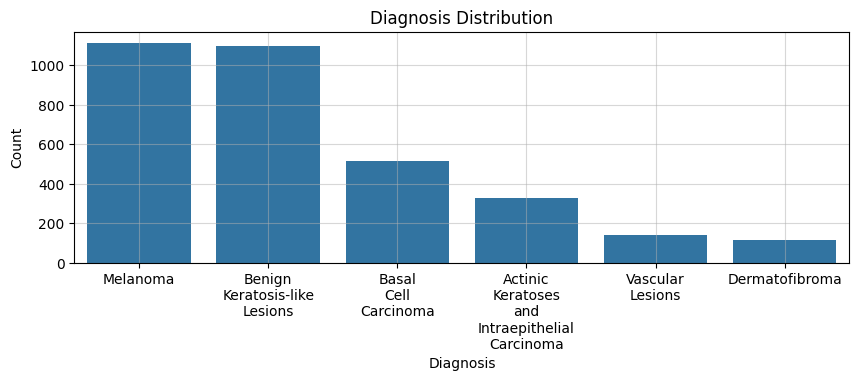

In [10]:
# diagnosis distribution
plt.figure(figsize=(10, 3))
sns.countplot(
    data=df, 
    x=df['dx'].map(lambda x: '\n'.join(diagnosis_map[x].split())), 
    order=['\n'.join(diagnosis_map[dx].split()) for dx in df['dx'].value_counts().index]
)
plt.title('Diagnosis Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.5)
plt.show()

In [11]:
if 'test_df' in globals(): 
    # diagnosis distribution
    plt.figure(figsize=(10, 3))
    sns.countplot(
        data=test_df, 
        x=test_df['dx'].map(lambda x: '\n'.join(diagnosis_map[x].split())), 
        order=['\n'.join(diagnosis_map[dx].split()) for dx in test_df['dx'].value_counts().index]
    )
    plt.title('Diagnosis Distribution')
    plt.xlabel('Diagnosis')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.5)
    plt.show()

In [12]:
# # NOTE: Uncomment this to put all images in the same folder
# # Define the source and destination directories
# source_dir = os.path.join(dataset_path, "HAM10000_images_part_1")
# source_dir2 = os.path.join(dataset_path, "HAM10000_images_part_2")
# destination_dir = os.path.join(dataset_path, "HAM10000_images")
# # Create the destination directory if it doesn't exist
# if not os.path.exists(destination_dir):
#     os.makedirs(destination_dir)
# # Move images from the first source directory
# for filename in os.listdir(source_dir):
#     src_path = os.path.join(source_dir, filename)
#     dst_path = os.path.join(destination_dir, filename)
#     shutil.move(src_path, dst_path)
# # Move images from the second source directory
# for filename in os.listdir(source_dir2):
#     src_path = os.path.join(source_dir2, filename)
#     dst_path = os.path.join(destination_dir, filename)
#     shutil.move(src_path, dst_path)
# # Remove the source directories if they are empty
# if not os.listdir(source_dir):
#     os.rmdir(source_dir)
# if not os.listdir(source_dir2):
#     os.rmdir(source_dir2)

In [13]:
# Root Directory to save the training checkpoints
if pretrained:
    pretrained_root_dir = os.path.join(dataset_path, "Pretrained")
    os.makedirs(pretrained_root_dir, exist_ok=True)

In [14]:
# # Test configuration
# x_dim, y_dim = 28, 28
# channel_size = 3
# batch_size = 32
# seed = 42
# torch.manual_seed(seed=seed)
# np.random.seed(seed)
# epochs = 1
# grid_sizes = [10]
# learning_rates = [0.001]
# hidden_layer_configs = [[64, 32]]
# criterion_type = 'CrossEntropyLoss'
# optim_type = 'Adam'
# grid_min = -1.2
# grid_max = 0.2
# inv_denominator = 0.5

In [15]:
df

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...,...
3305,10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
3306,10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
3307,10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
3308,10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [16]:
class SkinCancerDataset(torch.utils.data.Dataset):
    def __init__(self, root, csv_path, output_classes, transform=None):

        self.root = root
        self.transform = transform
        if isinstance(csv_path, str):
            df = pd.read_csv(csv_path)
        else:
            df = csv_path
        df = df.reindex()
        self.image_files = [os.path.splitext(f)[0] for f in os.listdir(root) if f.endswith('.jpg')]
        # print(len(self.image_files))
        # print(np.sum(df['image_id'].isin(self.image_files)))
        # print(len(df))
        assert np.sum(df['image_id'].isin(self.image_files)) == len(df)
        self.image_files = df['image_id'].values.tolist()

        # Create a mapping from image_id to class label
        # self.imageid_to_label = dict(zip(self.df['image_id'], self.df['dx']))

        # Map class names to integer indices
        classes = df['dx'].unique()
        # classes = sorted(df['dx'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        
        self.labels = [self.class_to_idx[cls] for cls in df['dx'].values]
        self.output_classes = output_classes

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # filename = self.image_files[index]
        # image_id = os.path.splitext(filename)[0]
        # img_path = os.path.join(self.root, filename)
        # image = np.asarray(Image.open(img_path).convert("RGB"))
        # label_name = self.imageid_to_label[image_id]
        # label = self.class_to_idx[label_name]
        # if self.transform:
        #     # If the transform is SelectiveAugment, pass label_name as well 
        #     if hasattr(self.transform, '__class__') and self.transform.__class__.__name__ == "SelectiveAugment":
        #         image = self.transform(image, label_name)
        #     else:
        #         image = self.transform(image = image)
        # if isinstance(image, dict):
        #     image = image['image']
        # return image.to(torch.float32), label
        img_path = os.path.join(self.root, f'{self.image_files[index]}.jpg')
        image = np.asarray(Image.open(img_path).convert("RGB"))
        label = self.labels[index]
        if self.transform:
            image = self.transform(image = image)
        if isinstance(image, dict):
            image = image['image']
        # print('Index :', index, 'Size :', image.size())
        return image.to(torch.float32), label
    
import albumentations as A

# # NOTE: This was for the selective augmentation (only augments on classes with less image counts than the median)
# # Add augmentations to data that needs it
# # Find classes with fewer image counts (e.g., less than median count)
# class_counts = df['dx'].value_counts()
# median_count = class_counts.median()
# minority_classes = class_counts[class_counts < median_count].index.tolist()
# print(f"Median class count: {median_count}")
# print(f"Minority classes (less than median count): {minority_classes}")
# minority_class_names = [diagnosis_map[c] for c in minority_classes]
# print(f"Minority class diagnosis names: {minority_class_names}")

# Define transforms
basic_transform = A.Compose([
    A.Resize(y_dim,x_dim),
    *([A.ToGray(channel_size,p=1),] if  channel_size == 1 else []),
    # A.Normalize(normalization='min_max'),
    # A.Normalize(mean=0.5, std=0.5),
    A.Normalize(),
    A.ToTensorV2(),
])

# Define the augmentation pipeline
augmented_transform = A.Compose([
    A.Resize(y_dim,x_dim),
    A.RandomResizedCrop(size=(x_dim,y_dim), scale=(0.08, 1.0), p=probability),
    A.HorizontalFlip(p=probability),
    A.VerticalFlip(p=probability),
    A.RGBShift(p=probability),
    A.RandomSunFlare(p=probability),
    A.RandomBrightnessContrast(p=probability),
    A.HueSaturationValue(p=probability),
    A.ColorJitter(p=probability),
    A.RandomRotate90(p=probability),
    A.Perspective(p=probability),
    A.MotionBlur(p=probability),
    A.ChannelShuffle(p=probability),
    A.ChannelDropout(p=probability),
    # A.Mosaic(p=probability),
    *([A.ToGray(channel_size,p=1),] if  channel_size == 1 else []),
    # A.Normalize(normalization='min_max'),
    # A.Normalize(mean=0.5, std=0.5),
    A.Normalize(),
    A.ToTensorV2(),
])

# Custom transform that applies augmentation only to minority classes
class SelectiveAugment:
    def __init__(self, minority_classes, basic_transform, augmented_transform, apply_augmentation):
        self.minority_classes = set(minority_classes)
        self.basic_transform = basic_transform
        self.augmented_transform = augmented_transform
        self.apply_augmentation = apply_augmentation  # True for train set, False otherwise

    def __call__(self, img, label_name):
        if self.apply_augmentation and label_name in self.minority_classes:
            return self.augmented_transform(img)
        else:
            return self.basic_transform(img)

In [17]:
# NOTE: We define minority classes as all of them to apply the augmentations to all of them:
minority_classes = df['dx'].value_counts().index.tolist()

In [18]:
# # Calculate lengths for splits: 75% train, 5% val, 20% test
# train_size = int(0.85 * len(df))
# val_size = len(df) - train_size

splits = [0.75, 0.09, 0.16]

# First, create the full dataset without transform (we'll set transforms per split)
# full_dataset = SkinCancerDataset(root=image_dir, csv_path=csv_path, transform=None)
full_dataset = SkinCancerDataset(root=image_dir, csv_path=df, output_classes=num_classes,transform=None)
# train_dataset, val_dataset = random_split(full_dataset, [0.85, 0.15])
train_dataset, val_dataset, test_dataset = random_split(full_dataset, splits)

# print(np.sum(df['dx'] == 'akiec'))
# print(np.sum(df.loc[train_dataset.indices, 'dx'] == 'akiec'))
# print(np.sum(df.loc[val_dataset.indices, 'dx'] == 'akiec'))

# test_dataset = SkinCancerDataset(root=image_test_dir, csv_path=test_df, output_classes=num_classes, transform=basic_transform)


In [19]:
if pretrained:
    df = pd.concat([df, nv_df]).reset_index()
    full_dataset = SkinCancerDataset(root=image_dir, csv_path=df, output_classes=num_classes,transform=None)
    
    train_dataset.dataset = full_dataset
    val_dataset.dataset = full_dataset
    test_dataset.dataset = full_dataset
    
    nv_ind = df[df['dx'] == 'nv'].index.to_list()
    tr_nv_ind, val_nv_ind, test_nv_ind = random_split(nv_ind, splits)

    train_dataset.indices += tr_nv_ind.indices
    val_dataset.indices += val_nv_ind.indices
    test_dataset.indices += test_nv_ind.indices
    

In [20]:
# Define the transforms for all splits
train_dataset.dataset.transform = augmented_transform
# SelectiveAugment(
#     minority_classes, 
#     basic_transform, 
#     augmented_transform, 
#     apply_augmentation=True  # Enable augmentation for training
# )
val_dataset.dataset.transform = basic_transform
# SelectiveAugment(
#     minority_classes, 
#     basic_transform, 
#     augmented_transform, 
#     apply_augmentation=False  # No augmentation for val
# )
test_dataset.dataset.transform = basic_transform

In [21]:
a,b = random_split(range(10),[0.8,0.2])
print(a.indices)
print(b.indices)

[5, 1, 4, 0, 9, 6, 3, 8]
[2, 7]


In [22]:
print(train_dataset.dataset.class_to_idx.keys())
print(sum(filter(lambda x : x == train_dataset.dataset.class_to_idx['akiec'], train_dataset.dataset.labels)))
print(sum(filter(lambda x : x == train_dataset.dataset.class_to_idx['akiec'], val_dataset.dataset.labels)))

dict_keys(['bkl', 'df', 'mel', 'vasc', 'bcc', 'akiec', 'nv'])
1635
1635


In [23]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 7512
Validation dataset size: 902
Test dataset size: 1601


In [24]:
train_dataset.indices[0]

109

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.40222222..0.96148455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46533608..1.4539869].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16771704..1.2884096].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.78534114..1.3842702].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14795786..1.6369934].


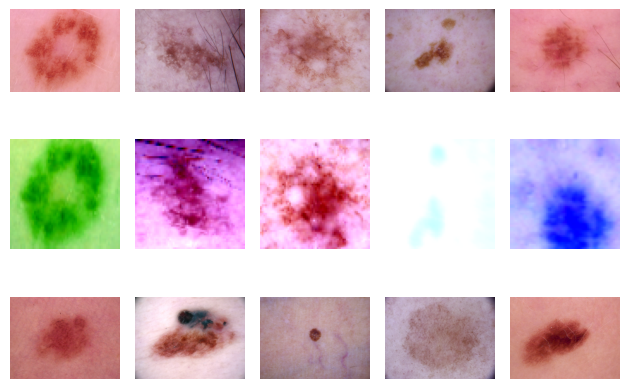

In [25]:
# Show images
fg, ax = plt.subplots(3, 5)

for i, (ax_trn, ax_alb, ax_tst) in enumerate(zip(*ax)):
    
    img_trn, dx_trn = df.loc[train_dataset.indices[int(len(train_dataset) * np.random.rand())], ['image_id', 'dx']]
    if 'test_df' in globals():
        img_tst, dx_tst = test_df.loc[int(len(test_df) * np.random.rand()), ['image_id', 'dx']]
    else:
        img_tst, dx_tst = df.loc[test_dataset.indices[int(len(test_dataset) * np.random.rand())], ['image_id', 'dx']]
    
    img_trn = np.asarray(Image.open(os.path.join(image_dir, f'{img_trn}.jpg')).convert('RGB'))
    is_ok = False
    while not is_ok:
        try :
            img_alb = np.moveaxis(np.asarray(augmented_transform(image = img_trn)['image']), 0, -1) * 0.5 + 0.5
            is_ok = True
        except Exception as e:
            print(e)
    img_tst = np.asarray(Image.open(os.path.join(image_test_dir, f'{img_tst}.jpg')).convert('RGB'))
    
    ax_trn.imshow(img_trn)
    ax_alb.imshow(img_alb)
    ax_tst.imshow(img_tst)
    ax_trn.set_axis_off()
    ax_alb.set_axis_off()
    ax_tst.set_axis_off()

fg.tight_layout() 
plt.show()
 

In [26]:
# # NOTE: This was for saving and appending the augmented images to the train dataframe
# # Directory to save augmented images
# augmented_dir = os.path.join(image_dir, "augmented")
# os.makedirs(augmented_dir, exist_ok=True)

# # Number of augmentations per original image
# n_augment = 5

# # Filter dataframe for minority classes
# minority_df = df[df['dx'].isin(minority_classes)]
# augmented_rows = []
# for idx, row in minority_df.iterrows():
#     image_id = row['image_id']
#     label = row['dx']
#     img_path = os.path.join(image_dir, f"{image_id}.jpg")
#     try:
#         image = Image.open(img_path).convert("RGB")
#         for i in range(n_augment):
#             # augmented_img = augmented_transform(image)
#             aug_image_id = f"{image_id}_aug{i}"
#             # save_path = os.path.join(augmented_dir, f"{aug_image_id}.png")
#             # save_image(augmented_img, save_path)
#             # Add new row for augmented image
#             new_row = row.copy()
#             new_row['image_id'] = aug_image_id
#             augmented_rows.append(new_row)
#     except Exception as e:
#         print(f"Error processing {img_path}: {e}")

# # Create Training DataFrame for augmented images
# augmented_df = pd.DataFrame(augmented_rows)
# train_indices = train_dataset.indices if hasattr(train_dataset, 'indices') else train_dataset
# train_df = df.iloc[train_indices]
# train_augmented_df = pd.concat([train_df, augmented_df], ignore_index=True)

# print(f"Original training samples: {len(train_df)}")
# print(f"Augmented samples: {len(augmented_df)}")
# print(f"Total samples in train_augmented_df: {len(train_augmented_df)}")

In [27]:
# WeightedRandomSampler is used to address class imbalance by sampling training examples with probability
# proportional to the inverse of their class frequency. This ensures that each mini-batch is more balanced,
# giving minority classes a higher chance to be sampled and preventing the model from being biased toward majority classes.
classes = full_dataset.class_to_idx.keys()

# Calculate class weights using the training set 
train_indices = train_dataset.indices # Get indices of the training samples
train_labels = df.loc[train_indices, 'dx']

class_sample_counts = train_labels.value_counts().reindex(classes, fill_value=0).values
class_weights = 1.0 / torch.tensor(class_sample_counts, dtype=torch.float)
# class_weights = class_weights / class_weights.sum() * len(class_sample_counts)

# Get the labels for each sample in the train_dataset
train_labels = train_labels.tolist()

dataset_len = int(len(classes) / np.sqrt(np.mean((1 / class_sample_counts) ** 2)))

In [28]:
for cls, count, weight in zip(classes, class_sample_counts, class_weights):
    print(f"Class: {cls:6} | Count: {count:4d} | Weight: {weight:.4f}")

Class: bkl    | Count: 1645 | Weight: 0.0006
Class: df     | Count:  167 | Weight: 0.0060
Class: mel    | Count: 1655 | Weight: 0.0006
Class: vasc   | Count:  217 | Weight: 0.0046
Class: bcc    | Count:  765 | Weight: 0.0013
Class: akiec  | Count:  489 | Weight: 0.0020
Class: nv     | Count: 2574 | Weight: 0.0004


In [29]:
# Map class names to indices
label_to_idx = full_dataset.class_to_idx
train_label_indices = [label_to_idx[label] for label in train_labels]

# WeightedRandomSampler:
#   - sample_weights: List of weights for each sample in the dataset (higher weight = higher chance to be sampled).
#   - num_samples: Number of samples to draw per epoch (usually set to the length of the training set).
#   - replacement: If True, samples are drawn with replacement (the same sample can be picked multiple times in an epoch).

# NOTE: # The generator= argument in WeightedRandomSampler, is only available in PyTorch 2.0+ 
# and requires Python 3.11+ (and the shortcut keyword requires Python 3.14+)
# That is why we use constant seed

num_workers = os.cpu_count()

torch.manual_seed(seed=seed)
sample_weights = [class_weights[label_idx].item() for label_idx in train_label_indices]
sampler = WeightedRandomSampler(sample_weights, num_samples=dataset_len, replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [30]:
# Check sampler
# print(train_labels.iloc[iter(sampler)].value_counts().reindex(full_dataset.classes, fill_value=0))


In [31]:
# Helper function to parse accuracy logs
def get_best_epoch_and_accuracy(acc_log_file_path, loss_log_file_path = None):
    best_accuracy = -1
    best_epoch = -1
    best_acc_loss = None
    with open(acc_log_file_path, 'r') as f:
        for line in f:
            if "Validation Accuracy" in line:
                parts = line.strip().split()
                epoch = int(parts[1][:-1])
                val_acc = float(parts[-1])
                if val_acc > best_accuracy:
                    best_accuracy = val_acc
                    best_epoch = epoch
    if loss_log_file_path is not None:
        with open(loss_log_file_path, 'r') as f:
            line = f.readlines()[best_epoch-1]
            parts = line.strip().split()
            best_acc_loss = float(parts[-1])
    return best_epoch, best_accuracy, best_acc_loss

# Helper function to parse loss logs
def get_best_epoch_and_loss(loss_log_file_path, acc_log_file_path=None):
    best_loss = float('inf')
    best_epoch = -1
    best_loss_acc = None
    with open(loss_log_file_path, 'r') as f:
        for line in f:
            if "Validation Loss" in line:
                parts = line.strip().split()
                epoch = int(parts[1][:-1])
                val_loss = float(parts[-1])
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_epoch = epoch
    if acc_log_file_path is not None:
        with open(acc_log_file_path, 'r') as f:
            line = f.readlines()[best_epoch-1]
            parts = line.strip().split()
            best_loss_acc = float(parts[-1])
    return best_epoch, best_loss, best_loss_acc

In [32]:
if pretrained:
    results_csv = os.path.join(pretrained_root_dir, f"hyperparam_results_{seed}.csv")
else :
    results_csv = os.path.join(root_dir, f"hyperparam_results_{seed}.csv")

# Initialize CSV log file
with open(results_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([
        "grid_size", "learning_rate", "hidden_layers", 
        "best_epoch_loss", "best_loss", "best_loss_accuracy", 
        "best_epoch_acc", "best_acc_loss", "best_accuracy", 
        "test_epoch", "test_loss", "test_accuracy", 
        "checkpoint_dir", "grid_min", "grid_max", "inv_denominator", "x_dim", "y_dim",
        "channel_size", "num_classes", "seed", "epochs", "scheduler", "optimizer", "criterion"
    ])

In [33]:
torch.cuda.empty_cache()

In [34]:
# Begin training
for grid_min in grid_min_list:
    for grid_max in grid_max_list:
        for inv_denominator in inv_denominator_list:
            for grid_size in grid_sizes:
                for lr in learning_rates:
                    for hidden_layers in hidden_layer_configs:
                        torch.manual_seed(seed)

                        dimension_list = [x_dim * y_dim * channel_size] + hidden_layers + [num_classes]
                        
                        model, _ = initialize_model(
                            root_dir=root_dir,
                            dimension=dimension_list,
                            grid_size=grid_size,
                            lr=lr,
                            sched=sched_type,
                            optim=optim_type,
                            criterion=criterion_type,
                            grid_min=grid_min,
                            grid_max=grid_max,
                            inv_denominator=inv_denominator,
                            x_dim=x_dim,
                            y_dim=y_dim,
                            channel_size=channel_size,
                            seed=seed
                        )
                        if pretrained:
                            checkpoint_dir = checkpoint_dir_name(
                                criterion_type, optim_type, sched_type, seed, dimension_list, lr,
                                grid_size, grid_min, grid_max, inv_denominator, root_dir
                            )
                            best_model_path = os.path.join(checkpoint_dir, f"epoch_best", "model_checkpoint.pth")
                            model, *_ = load_checkpoint(model, checkpoint_path=best_model_path) 
                            
                            pretrained_lr = lr / 10
                        else :
                            pretrained_root_dir = root_dir
                            pretrained_lr = lr
                            
                        checkpoint_dir = checkpoint_dir_name(
                            criterion_type, optim_type, sched_type, seed, dimension_list, pretrained_lr,
                            grid_size, grid_min, grid_max, inv_denominator, pretrained_root_dir
                        )
                        model.to(device)
                        print(model.parameters())

                        print(f"\n[INFO] Training | grid_size={grid_size}, lr={pretrained_lr}, layers={hidden_layers}")
                        print("Checkpoint dir:", checkpoint_dir)

                        criterion = criterion_type
                        optimizer = torch.optim.Adam(model.parameters(), lr=pretrained_lr, weight_decay=1e-4)
                        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.9,patience=5)

                        train_and_validate_model(
                            model=model,
                            train_loader=train_loader,
                            val_loader=val_loader,
                            criterion=criterion,
                            checkpoint_dir=checkpoint_dir,
                            optimizer=optimizer,
                            scheduler=scheduler,
                            epochs=epochs,
                            patience=50,
                            device=device
                        )



[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.


/home/gvenit/Projects/kan-fpga/test/marr/checkpoint_config.py:180: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

{'epoch': 162, 'model_state_dict': OrderedDict({'total_ops': tensor([0.], dtype=torch.float64), 'total_params': tensor([0.], dtype=torch.float64), 'layers.total_ops': tensor([0.], dtype=torch.float64), 'layers.total_params': tensor([0.], dtype=torch.float64), 'layers.0.total_ops': tensor([0.], dtype=torch.float64), 'layers.0.total_params': tensor([0.], dtype=torch.float64), 'layers.0.rbf.grid': tensor([-1.9293, -1.2215, -0.5208,  0.2020]), 'layers.0.rbf.inv_denominator': tensor(1.5588), 'layers.0.rbf.total_ops': tensor([0.], dtype=torch.float64), 'layers.0.rbf.total_params': tensor([0.], dtype=torch.float64), 'layers.0.linear.weight': tensor([[ 2.4694e-03, -1.6282e-03,  3.2156e-05,  ...,  8.8315e-04,
          7.1324e-04,  4.8027e-03],
        [ 5.2901e-03, -2.6970e-03, -8.4036e-03,  ...,  1.8859e-03,
          4.7572e-03, -6.8918e-03],
        [-3.1296e-03, -1.0404e-02,  2.7151e-03,  ..., -7.8997e-03,
         -3.7348e-03,  1.8877e-03],
        ...,
        [-2.1304e-04,  8.7175e-03, 

Epoch [1/500]:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# from importlib import reload
# import training_and_val
# reload(training_and_val)
# validate_model = training_and_val.validate_model

Best Validation Loss:     Epoch: 498 | Loss: 0.0945 | Accuracy: 88.14%
Best Validation Accuracy: Epoch: 463 | Loss: 0.0952 | Accuracy: 88.14%
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.


/home/gvenit/Projects/kan-fpga/test/marr/checkpoint_config.py:180: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

Checkpoint loaded from /home/gvenit/Projects/kan-fpga/test/marr/Dataset/Pretrained/45482/BCELoss/Adam/ReduceOnPlateau/3.0e-05/[12288,1024,7]/[4]/-2.0e+00/2.5e-01/1.5e+00/epoch_best/model_checkpoint.pth. Next epoch is 498.
Model loaded from checkpoint: /home/gvenit/Projects/kan-fpga/test/marr/Dataset/Pretrained/45482/BCELoss/Adam/ReduceOnPlateau/3.0e-05/[12288,1024,7]/[4]/-2.0e+00/2.5e-01/1.5e+00/epoch_best/model_checkpoint.pth


Validating:   0%|          | 0/4 [00:00<?, ?batch/s]

F1 Score: 0.8580
Recall: 0.8582
Accuracy: 85.82%
Confusion Matrix:
[[262   5  40   1  18  10  13]
 [  5  29   1   0   3   0   0]
 [ 38   0 311   4   6   9   3]
 [  1   0   1  34   0   0   0]
 [ 13   5   7   0 137   7   3]
 [  5   4   4   0   8  75   1]
 [  4   3   1   0   1   3 526]]


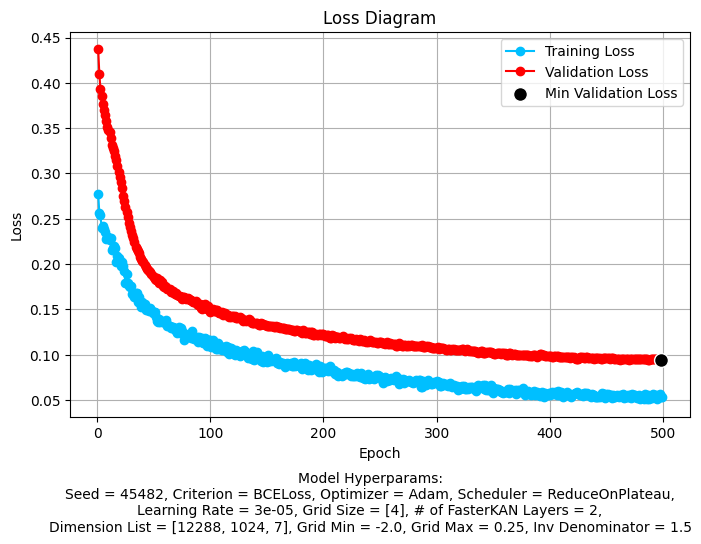

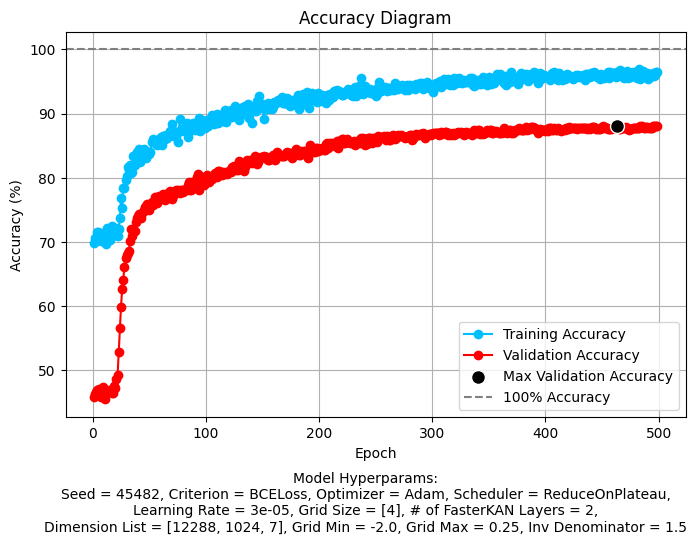

Best Validation Loss:     Epoch: 488 | Loss: 0.0899 | Accuracy: 89.25%
Best Validation Accuracy: Epoch: 485 | Loss: 0.0904 | Accuracy: 89.36%
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.


/home/gvenit/Projects/kan-fpga/test/marr/checkpoint_config.py:180: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

Checkpoint loaded from /home/gvenit/Projects/kan-fpga/test/marr/Dataset/Pretrained/45482/BCELoss/Adam/ReduceOnPlateau/3.0e-05/[12288,1024,7]/[4]/-2.0e+00/2.5e-01/2.0e+00/epoch_best/model_checkpoint.pth. Next epoch is 488.
Model loaded from checkpoint: /home/gvenit/Projects/kan-fpga/test/marr/Dataset/Pretrained/45482/BCELoss/Adam/ReduceOnPlateau/3.0e-05/[12288,1024,7]/[4]/-2.0e+00/2.5e-01/2.0e+00/epoch_best/model_checkpoint.pth


Validating:   0%|          | 0/4 [00:00<?, ?batch/s]

F1 Score: 0.8714
Recall: 0.8713
Accuracy: 87.13%
Confusion Matrix:
[[277   2  30   2  14  10  14]
 [  6  29   1   0   2   0   0]
 [ 35   1 318   5   3   5   4]
 [  2   0   1  31   0   0   2]
 [ 10   4   4   0 143   9   2]
 [  6   3   3   0   8  76   1]
 [  7   1   2   1   1   5 521]]


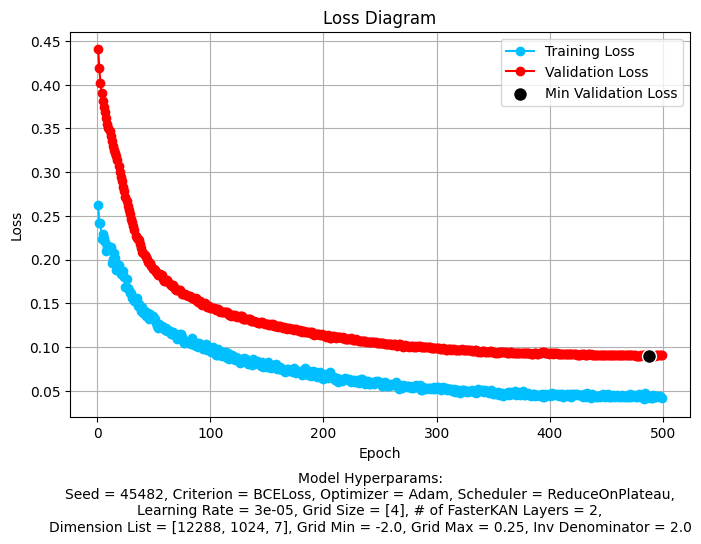

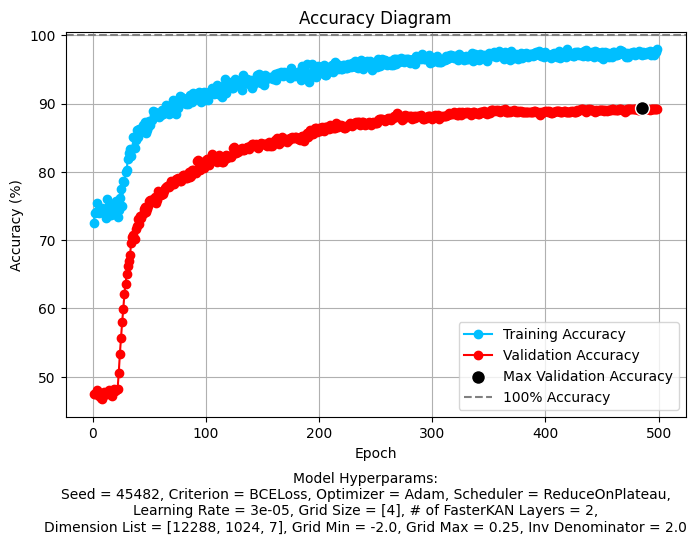

Best Validation Loss:     Epoch: 487 | Loss: 0.0800 | Accuracy: 89.91%
Best Validation Accuracy: Epoch: 474 | Loss: 0.0807 | Accuracy: 90.24%
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.


/home/gvenit/Projects/kan-fpga/test/marr/checkpoint_config.py:180: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

Checkpoint loaded from /home/gvenit/Projects/kan-fpga/test/marr/Dataset/Pretrained/45482/BCELoss/Adam/ReduceOnPlateau/3.0e-05/[12288,1024,7]/[4]/-2.0e+00/2.5e-01/2.5e+00/epoch_best/model_checkpoint.pth. Next epoch is 487.
Model loaded from checkpoint: /home/gvenit/Projects/kan-fpga/test/marr/Dataset/Pretrained/45482/BCELoss/Adam/ReduceOnPlateau/3.0e-05/[12288,1024,7]/[4]/-2.0e+00/2.5e-01/2.5e+00/epoch_best/model_checkpoint.pth


Validating:   0%|          | 0/4 [00:00<?, ?batch/s]

F1 Score: 0.8909
Recall: 0.8907
Accuracy: 89.07%
Confusion Matrix:
[[293   2  21   2   8   8  15]
 [  7  27   0   0   3   0   1]
 [ 27   0 328   1   5   5   5]
 [  1   0   3  32   0   0   0]
 [  5   3   3   1 152   6   2]
 [  3   3   3   0   8  79   1]
 [  8   2   2   1   4   6 515]]


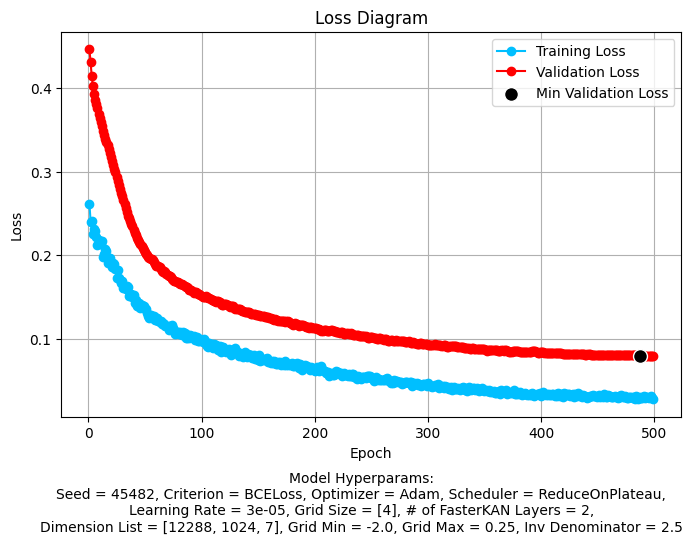

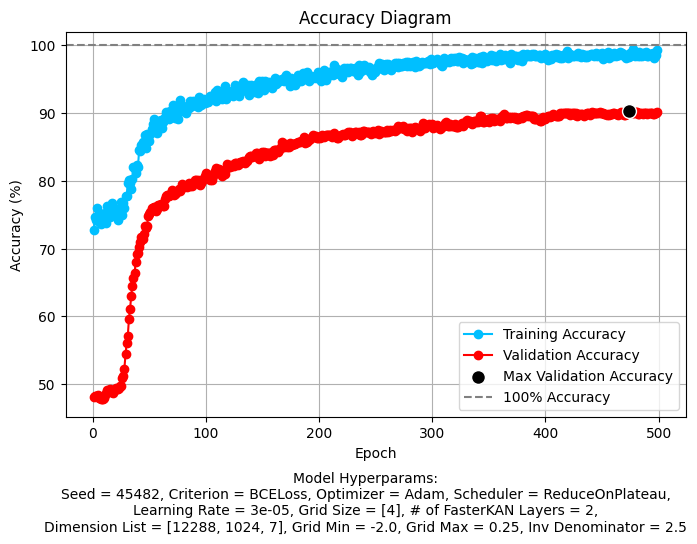

In [ ]:
# Begin testing
for grid_min in grid_min_list:
    for grid_max in grid_max_list:
        for inv_denominator in inv_denominator_list:
            for grid_size in grid_sizes:
                for lr in learning_rates:
                    for hidden_layers in hidden_layer_configs:
                        torch.manual_seed(seed)
                        
                        dimension_list = [x_dim * y_dim * channel_size] + hidden_layers + [num_classes]
                        
                        if pretrained:
                            pretrained_lr = lr / 10
                        else :
                            pretrained_root_dir = root_dir
                            pretrained_lr = lr
                            
                        checkpoint_dir = checkpoint_dir_name(
                            criterion_type, optim_type, sched_type, seed, dimension_list, pretrained_lr,
                            grid_size, grid_min, grid_max, inv_denominator, pretrained_root_dir
                        )
                        
                        acc_log_path = os.path.join(checkpoint_dir, "accuracy_logs.txt")
                        loss_log_path = os.path.join(checkpoint_dir, "loss_logs.txt")
                        best_epoch_loss, best_loss, best_loss_acc = get_best_epoch_and_loss(loss_log_path,acc_log_path)
                        best_epoch_acc, best_accuracy, best_acc_loss = get_best_epoch_and_accuracy(acc_log_path,loss_log_path)
                        print(f"Best Validation Loss:     Epoch: {best_epoch_loss} | Loss: {best_loss:.4f} | Accuracy: {best_loss_acc:.2f}%")
                        print(f"Best Validation Accuracy: Epoch: {best_epoch_acc} | Loss: {best_acc_loss:.4f} | Accuracy: {best_accuracy:.2f}%")

                        model, _ = initialize_model(
                            root_dir=pretrained_root_dir,
                            dimension=dimension_list,
                            grid_size=grid_size,
                            lr=pretrained_lr,
                            sched=sched_type,
                            optim=optim_type,
                            criterion=criterion_type,
                            grid_min=grid_min,
                            grid_max=grid_max,
                            inv_denominator=inv_denominator,
                            x_dim=x_dim,
                            y_dim=y_dim,
                            channel_size=channel_size,
                            seed=seed
                        )
                        
                        criterion = criterion_type

                        # Load best model
                        best_model_path = os.path.join(checkpoint_dir, f"epoch_best", "model_checkpoint.pth")
                        test_loss, test_accuracy = validate_model(
                            model=model,
                            val_loader=test_loader,
                            criterion=criterion,
                            checkpoint_path=best_model_path,
                            optimizer=optim_type,
                            device=device,
                            metrics_flag=True
                        )

                        # Log to CSV
                        with open(results_csv, mode='a', newline='', encoding='utf-8') as file:
                            writer = csv.writer(file)
                            writer.writerow([
                                grid_size,
                                lr,
                                str(hidden_layers),
                                best_epoch_loss,
                                best_loss,
                                best_loss_acc,
                                best_epoch_acc,
                                best_acc_loss,
                                best_accuracy,
                                'best',
                                test_loss,
                                test_accuracy,
                                checkpoint_dir,
                                grid_min,
                                grid_max,
                                inv_denominator,
                                x_dim,
                                y_dim,
                                channel_size,
                                num_classes,
                                seed,
                                epochs,
                                optim_type,
                                criterion_type
                            ])
                            
                        # Load best model
                        # last_model_path = os.path.join(checkpoint_dir, f"epoch_last", "model_checkpoint.pth")
                        # validate_model(
                        #     model=model,
                        #     val_loader=test_loader,
                        #     criterion=criterion,
                        #     checkpoint_path=last_model_path,
                        #     optimizer=optim_type,
                        #     device=device,
                        #     metrics_flag=True
                        # )

                        # Plot training logs
                        loss_plotter(checkpoint_dir)
                        accuracy_plotter(checkpoint_dir)


In [ ]:

for grid_min in grid_min_list:
    for grid_max in grid_max_list:
        for inv_denominator in inv_denominator_list:
            for grid_size in grid_sizes:
                for lr in learning_rates:
                    for hidden_layers in hidden_layer_configs:
            
                        dimension_list = [x_dim * y_dim * channel_size] + hidden_layers + [num_classes]
                        
                        if not pretrained:
                            pretrained_root_dir = root_dir
                            
                        checkpoint_dir = checkpoint_dir_name(
                            criterion_type, optim_type, sched_type, seed, dimension_list, lr,
                            grid_size, grid_min, grid_max, inv_denominator, pretrained_root_dir
                        )
                        
                        model, _ = initialize_model(
                            root_dir=root_dir,
                            dimension=dimension_list,
                            grid_size=grid_size,
                            lr=lr,
                            sched=sched_type,
                            optim=optim_type,
                            criterion=criterion_type,
                            grid_min=grid_min,
                            grid_max=grid_max,
                            inv_denominator=inv_denominator,
                            x_dim=x_dim,
                            y_dim=y_dim,
                            channel_size=channel_size,
                            seed=seed
                        )
                        
                        # Load best model
                        best_model_path = os.path.join(checkpoint_dir, f"epoch_best", "model_checkpoint.pth")
                        model, *_ = load_checkpoint(model, checkpoint_path=best_model_path) 
                        
                        print(model.state_dict())

In [ ]:
import torchvision
import torch.nn as nn

class ShuffleNetV2X15(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()

        self.weights = torchvision.models.ShuffleNet_V2_X1_5_Weights.IMAGENET1K_V1
        # Load the model with the pretrained weights
        self.model = torchvision.models.shufflenet_v2_x1_5(weights=self.weights, progress=True)

        # Freeze the all layers
        for param in self.model.parameters():
            param.requires_grad = False
        # Unfreeze the last convolutional layer
        for param in self.model.conv5.parameters():
            param.requires_grad = True

        # Modify the classification head
        self.model.fc = nn.Linear(
            in_features=1024,
            out_features=num_classes,
            bias=True
        )
        # Initialize the new classification head with Xavier
        nn.init.xavier_uniform_(self.model.fc.weight)
        if self.model.fc.bias is not None:
            nn.init.zeros_(self.model.fc.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


In [ ]:

for lr in learning_rates:
    model = ShuffleNetV2X15(num_classes)
    shufflenet_checkpoint_dir = os.path.join(dataset_path,'shufflenet',str(lr))

    print(f"\n[INFO] Training")
    print("Checkpoint dir:", shufflenet_checkpoint_dir)

    criterion = criterion_type
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, momentum=0.05)
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5,0.9),weight_decay=1e-3)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.75,patience=10)

    train_and_validate_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        checkpoint_dir=shufflenet_checkpoint_dir,
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=epochs,
        device=device
    )



In [ ]:
from torchinfo import summary
for lr in learning_rates:

        
    model = ShuffleNetV2X15(num_classes)
    shufflenet_checkpoint_dir = os.path.join(dataset_path,'shufflenet',str(lr))
    log_path = os.path.join(shufflenet_checkpoint_dir, "accuracy_logs.txt")
    best_epoch, best_val_accuracy = get_best_epoch_and_accuracy(log_path)
    print(f"Best Epoch: {best_epoch} | Best Validation Accuracy: {best_val_accuracy:.2f}%")

    criterion = criterion_type
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, momentum=0.05)
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5,0.9),weight_decay=1e-3)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.75,patience=10)
    
    # Load best model
    best_model_path = os.path.join(shufflenet_checkpoint_dir, f"epoch_best", "model_checkpoint.pth")
    validate_model(
        model=model,
        val_loader=test_loader,
        criterion=criterion,
        checkpoint_path=best_model_path,
        optimizer=optim_type,
        device=device,
        metrics_flag=True
    )
    
    # sys.std = tmp
        